# EDA по датасету MURA

#### Команда 2 Тема 12

Выполнили: Бартов Алексей,
Иванов Дмитрий, 	
Махаммаджонов Суннатилла, 	
Пащенко Леона.


### Загрузка библиотек и данных

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from pathlib import Path

# Настройки отображения
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (8, 4)

In [3]:
#Путь к корневой папке MURA-v1.0
DATA_ROOT = "MURA-v1.1" 

# Проверка наличия папки
assert os.path.exists(DATA_ROOT), f"Папка {DATA_ROOT} не найдена. Укажите правильный путь."

In [4]:
def parse_study_path(study_path: str):
    """Извлекает метаинформацию из пути к исследованию."""
    parts = Path(study_path).parts
    split = parts[-4]
    anatomy = parts[-3]
    patient_id = parts[-2]
    study_name = parts[-1]
    label = 1 if 'positive' in study_name else 0  # 1 = abnormal, 0 = normal
    return {
        'split': split,
        'anatomy': anatomy,
        'patient_id': patient_id,
        'study_id': study_name,
        'label': label,
        'path': study_path
    }

def build_dataframe(root_dir: str):
    records = []
    for split in ['train', 'valid']:
        split_path = os.path.join(root_dir, split)
        if not os.path.isdir(split_path):
            continue
        for anatomy in os.listdir(split_path):
            anatomy_path = os.path.join(split_path, anatomy)
            if not os.path.isdir(anatomy_path):
                continue
            for patient in os.listdir(anatomy_path):
                patient_path = os.path.join(anatomy_path, patient)
                for study in os.listdir(patient_path):
                    study_path = os.path.join(patient_path, study)
                    if os.path.isdir(study_path):
                        records.append(parse_study_path(study_path))
    return pd.DataFrame(records)

# Сбор данных
df = build_dataframe(DATA_ROOT)
print(f"✅ Загружено {len(df)} исследований от {df['patient_id'].nunique()} пациентов.")

✅ Загружено 14656 исследований от 11967 пациентов.


### Первичный анализ данных

In [5]:
print("📊 Общая статистика:")
print(f"- Всего исследований: {len(df)}")
print(f"- Уникальных пациентов: {df['patient_id'].nunique()}")
print(f"- Анатомических типов: {df['anatomy'].nunique()}")
print(f"- Сплиты: {df['split'].value_counts().to_dict()}")

# Распределение меток
label_counts = df['label'].value_counts()
print(f"\n- Норма (0): {label_counts[0]} ({label_counts[0]/len(df)*100:.1f}%)")
print(f"- Патология (1): {label_counts[1]} ({label_counts[1]/len(df)*100:.1f}%)")

📊 Общая статистика:
- Всего исследований: 14656
- Уникальных пациентов: 11967
- Анатомических типов: 7
- Сплиты: {'train': 13457, 'valid': 1199}

- Норма (0): 8941 (61.0%)
- Патология (1): 5715 (39.0%)


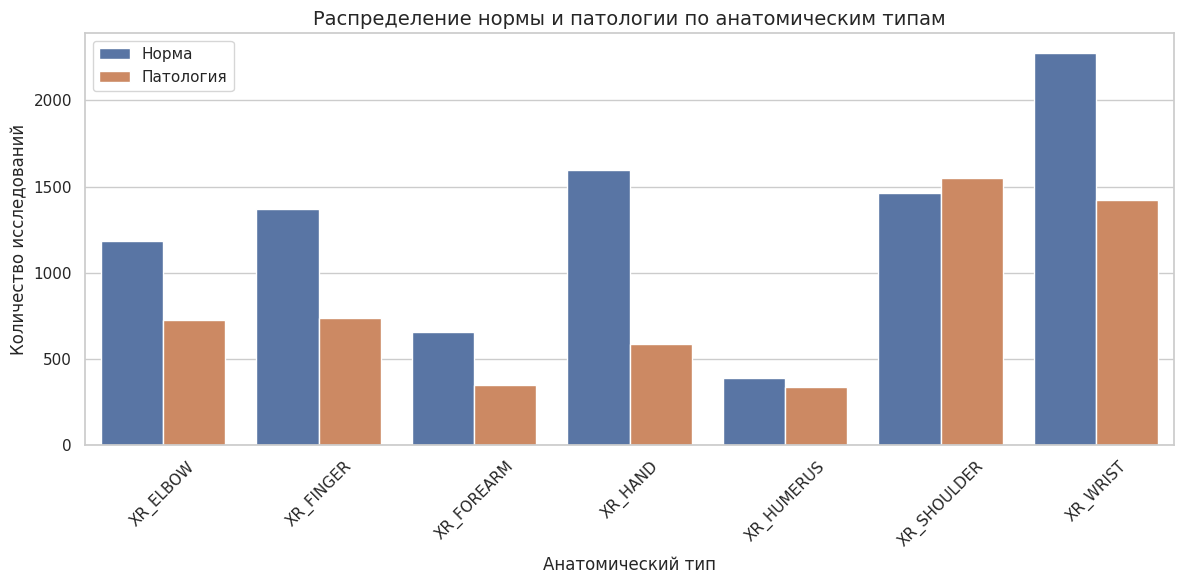

In [6]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='anatomy', hue='label', order=sorted(df['anatomy'].unique()))
plt.title("Распределение нормы и патологии по анатомическим типам", fontsize=14)
plt.xlabel("Анатомический тип")
plt.ylabel("Количество исследований")
plt.xticks(rotation=45)
plt.legend(['Норма', 'Патология'])
plt.tight_layout()
plt.show()

In [7]:
train_patients = set(df[df['split'] == 'train']['patient_id'])
valid_patients = set(df[df['split'] == 'valid']['patient_id'])
intersection = train_patients & valid_patients

print(f"🟥 Пересечение пациентов между train и valid: {len(intersection)}")
if len(intersection) == 0:
    print("✅ Patient-level split соблюдён!")
else:
    print("⚠️  Нарушение patient-level split!")

🟥 Пересечение пациентов между train и valid: 0
✅ Patient-level split соблюдён!


📸 Среднее число снимков на исследование: 2.73
Мин/Макс: 1 / 11


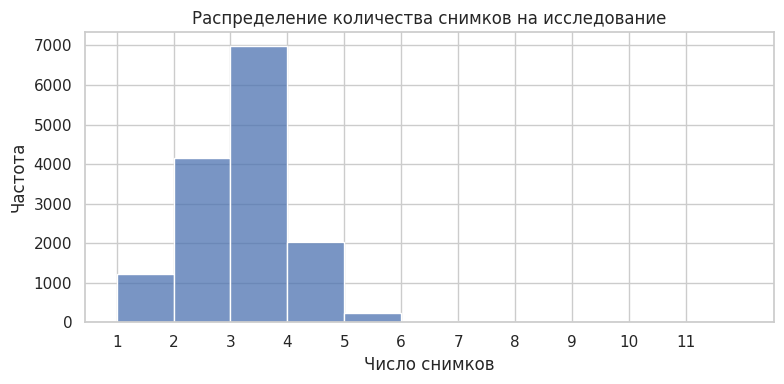

In [8]:
def count_images_in_study(study_path):
    return len([f for f in os.listdir(study_path) 
                if f.lower().endswith(('.png', '.jpg', '.jpeg', '.dcm'))])

df['n_images'] = df['path'].apply(count_images_in_study)

print(f"📸 Среднее число снимков на исследование: {df['n_images'].mean():.2f}")
print(f"Мин/Макс: {df['n_images'].min()} / {df['n_images'].max()}")

# Гистограмма
#plt.figure(figsize=(8, 4))
sns.histplot(df['n_images'], bins=range(1, df['n_images'].max() + 2), kde=False)
plt.title("Распределение количества снимков на исследование")
plt.xlabel("Число снимков")
plt.ylabel("Частота")
plt.xticks(range(1, df['n_images'].max() + 1))
plt.tight_layout()
plt.show()

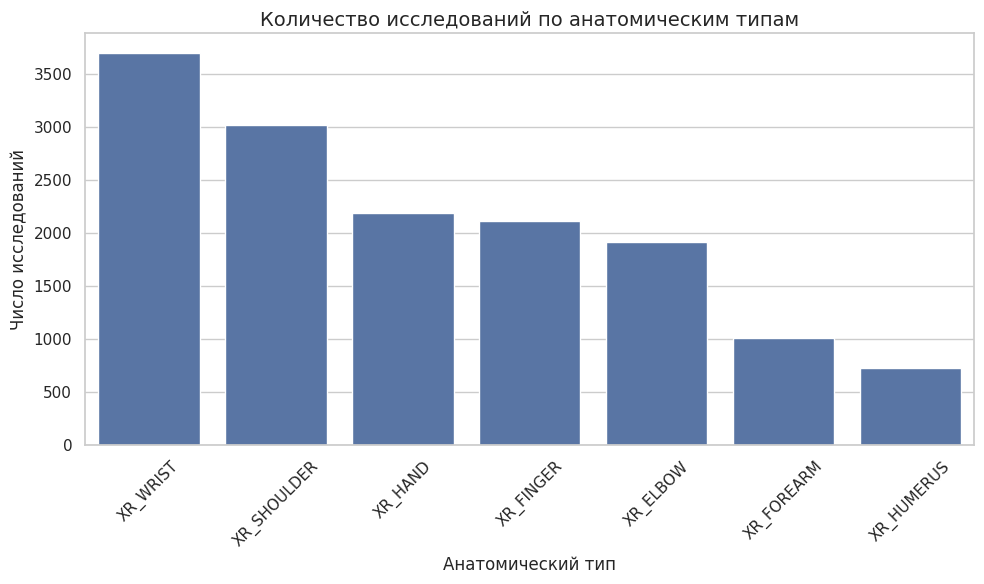

In [9]:
plt.figure(figsize=(10, 6))
anatomy_counts = df['anatomy'].value_counts()
sns.barplot(x=anatomy_counts.index, y=anatomy_counts.values)
plt.title("Количество исследований по анатомическим типам", fontsize=14)
plt.xlabel("Анатомический тип")
plt.ylabel("Число исследований")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

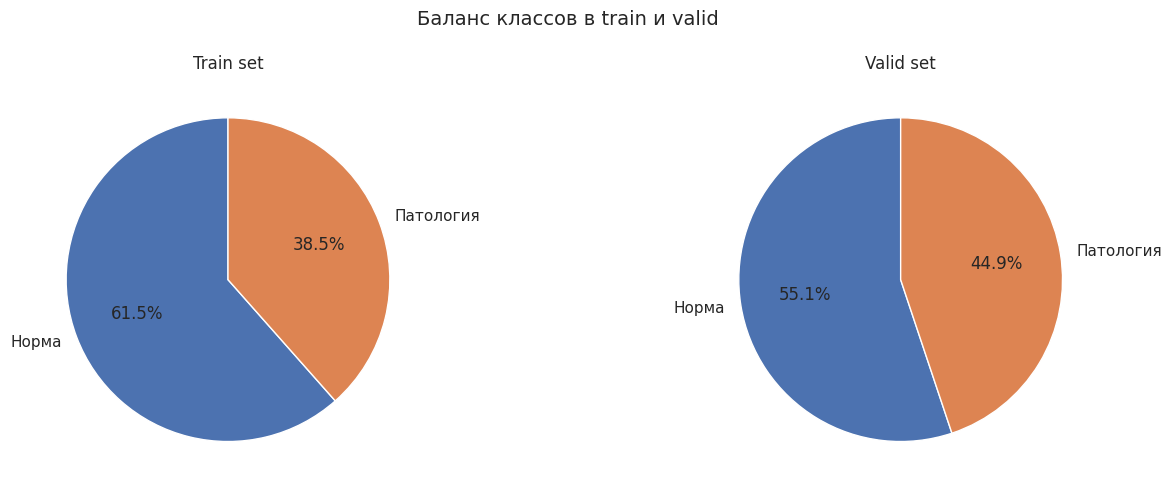

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for i, split in enumerate(['train', 'valid']):
    subset = df[df['split'] == split]
    labels = subset['label'].value_counts()
    axes[i].pie(labels, labels=['Норма', 'Патология'], autopct='%1.1f%%', startangle=90)
    axes[i].set_title(f"{split.capitalize()} set")

plt.suptitle("Баланс классов в train и valid", fontsize=14)
plt.tight_layout()
plt.show()

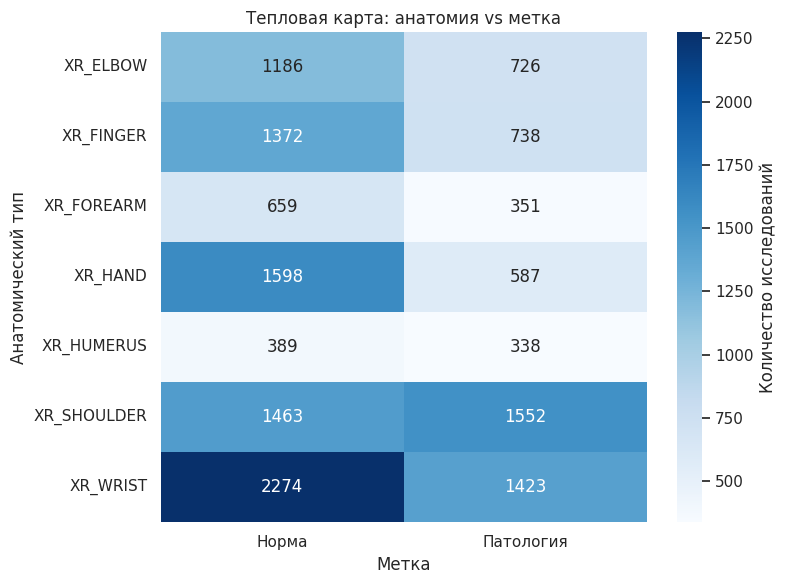

In [11]:
heatmap_data = df.groupby(['anatomy', 'label']).size().unstack(fill_value=0)
heatmap_data.columns = ['Норма', 'Патология']

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="Blues", cbar_kws={'label': 'Количество исследований'})
plt.title("Тепловая карта: анатомия vs метка")
plt.ylabel("Анатомический тип")
plt.xlabel("Метка")
plt.tight_layout()
plt.show()

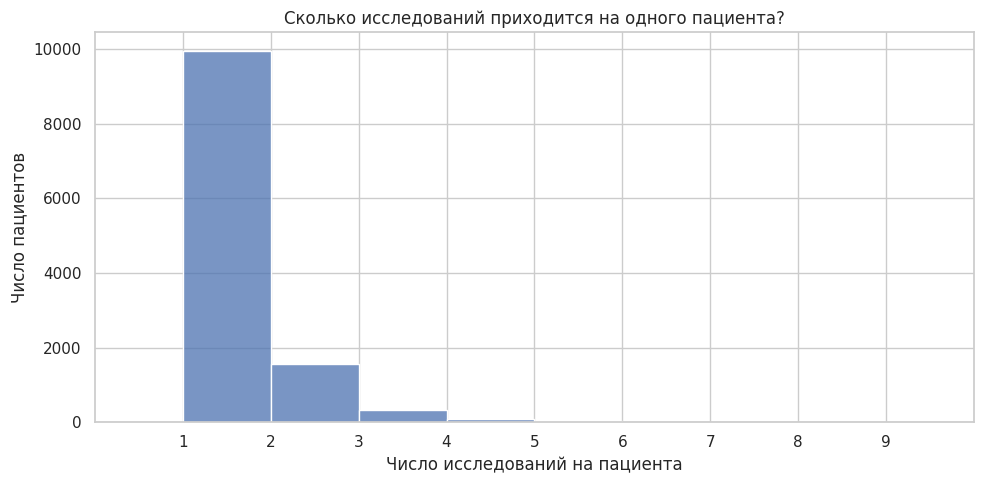

Макс. исследований у одного пациента: 9
Пациентов с >1 исследованием: 2015


In [12]:
patient_study_counts = df.groupby('patient_id').size()

plt.figure(figsize=(10, 5))
sns.histplot(patient_study_counts, bins=range(1, patient_study_counts.max() + 2), kde=False)
plt.title("Сколько исследований приходится на одного пациента?")
plt.xlabel("Число исследований на пациента")
plt.ylabel("Число пациентов")
plt.xticks(range(1, min(11, patient_study_counts.max() + 1)))
plt.xlim(0, 10)  # большинство — 1–3
plt.tight_layout()
plt.show()

print(f"Макс. исследований у одного пациента: {patient_study_counts.max()}")
print(f"Пациентов с >1 исследованием: {(patient_study_counts > 1).sum()}")

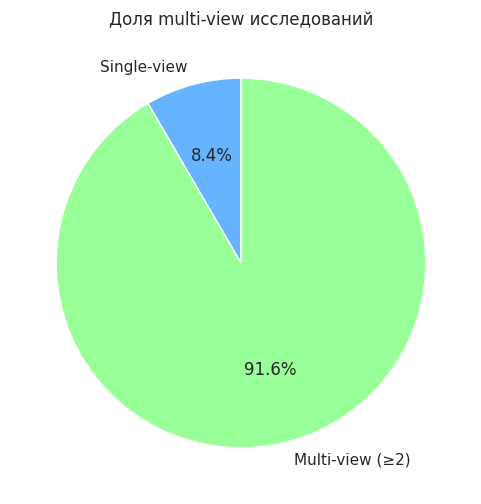

In [13]:
multi_view_ratio = (df['n_images'] >= 2).mean()
single_view_ratio = 1 - multi_view_ratio

plt.figure(figsize=(6, 6))
plt.pie([single_view_ratio, multi_view_ratio],
        labels=['Single-view', 'Multi-view (≥2)'],
        autopct='%1.1f%%',
        colors=['#66b3ff', '#99ff99'],
        startangle=90)
plt.title("Доля multi-view исследований")
plt.show()

C:\Users\dmitr\AppData\Local\Temp\ipykernel_25368\1642800636.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=values, palette='colorblind')


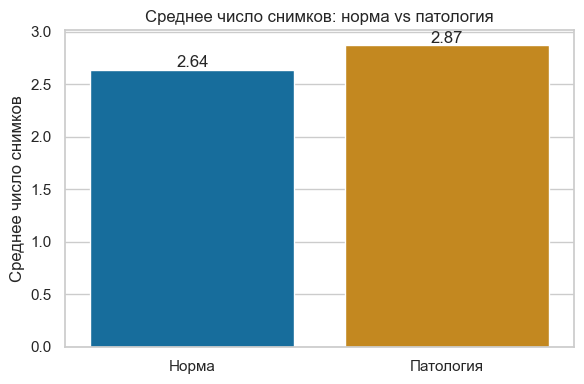

In [18]:
avg_views_by_label = df.groupby('label')['n_images'].mean()
labels = ['Норма', 'Патология']
values = [avg_views_by_label[0], avg_views_by_label[1]]

plt.figure(figsize=(6, 4))
sns.barplot(x=labels, y=values, palette='colorblind')
plt.title("Среднее число снимков: норма vs патология")
plt.ylabel("Среднее число снимков")
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center')
plt.tight_layout()
plt.show()

In [14]:
from sklearn.metrics import cohen_kappa_score, accuracy_score

# Пример: симуляция предсказаний (все "норма")
y_true = df[df['split'] == 'valid']['label']
y_pred_all_normal = np.zeros_like(y_true)

acc = accuracy_score(y_true, y_pred_all_normal)
kappa = cohen_kappa_score(y_true, y_pred_all_normal)

print(f"Если предсказывать ВСЕГДА 'норма':")
print(f"- Accuracy: {acc:.3f}")
print(f"- Cohen’s Kappa: {kappa:.3f}  ← гораздо более честная метрика!")

Если предсказывать ВСЕГДА 'норма':
- Accuracy: 0.551
- Cohen’s Kappa: 0.000  ← гораздо более честная метрика!


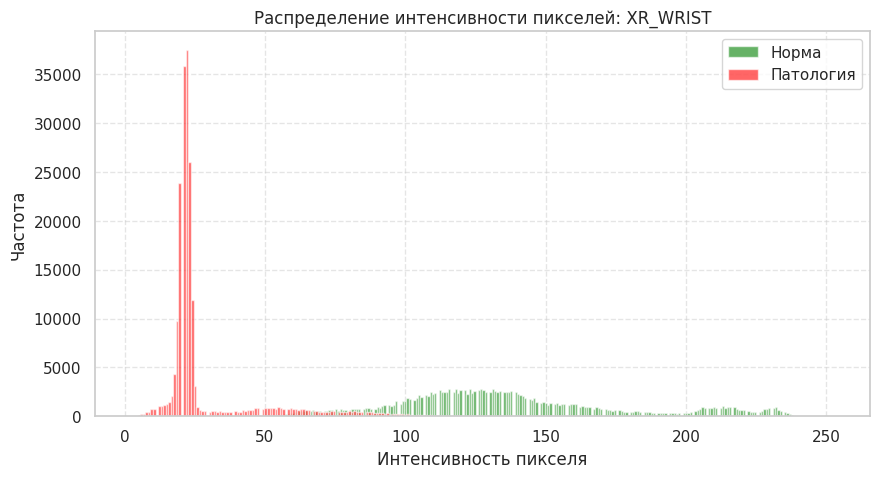

In [15]:
def plot_pixel_histogram(study_path, label_name, color):
    image_files = [os.path.join(study_path, f) for f in os.listdir(study_path)
                   if f.lower().endswith(('.png', '.jpg'))]
    if not image_files:
        return
    img = np.array(Image.open(image_files[0]).convert('L'))
    plt.hist(img.ravel(), bins=256, color=color, alpha=0.6, label=label_name)

# Выберем по одному случаю нормы и патологии из одного анатомического типа
anatomy = 'XR_WRIST'
norm_study = df[(df['anatomy'] == anatomy) & (df['label'] == 0)].iloc[0]['path']
abnorm_study = df[(df['anatomy'] == anatomy) & (df['label'] == 1)].iloc[0]['path']

plt.figure(figsize=(10, 5))
plot_pixel_histogram(norm_study, 'Норма', 'green')
plot_pixel_histogram(abnorm_study, 'Патология', 'red')
plt.xlabel("Интенсивность пикселя")
plt.ylabel("Частота")
plt.title(f"Распределение интенсивности пикселей: {anatomy}")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

### Выводы по первичному анализу:


📊 Общая статистика:
- Всего исследований: 14656
- Уникальных пациентов: 11967
- Анатомических типов: 7
- Сплиты: {'train': 13457, 'valid': 1199}

- Норма (0): 8941 (61.0%)
- Патология (1): 5715 (39.0%)

🟥 Пересечение пациентов между train и valid: 0
✅ Patient-level split соблюдён!

📸 Среднее число снимков на исследование: 2.73
Мин/Макс: 1 / 11

Макс. исследований у одного пациента: 9
Пациентов с >1 исследованием: 2015

Мы имеем датасет с несбалансированной выборкой и бинарной целевой переменной. Будем решать задачу классификации для различных исследований, учитывая разное распределение целевой переменной для разных групп исследований.

Предложения авторов соревнования по датасету MURA:

Если предсказывать ВСЕГДА 'норма':
- Accuracy: 0.551
- Cohen’s Kappa: 0.000  ← гораздо более честная метрика!

Для следующего этапа выдвинем гипотезу на основании исследования интенсивности пикселей для кистей, что с использованием классических методов машинного обучения можно эффективно разделять норманальные и абнормальные изображения по интенсивности.

In [16]:
import os
import cv2
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Исследование размеров изображений

In [ ]:
from IPython.display import Markdown
#### 1. Анализ уникальных размеров
unique_sizes = df_dimensions[['width', 'height']].drop_duplicates()
num_unique_sizes = len(unique_sizes)
def get_body_part_from_path(file_path_str):
    parts = Path(file_path_str).parts
    for i, part in enumerate(parts):
        if part == 'train' or part == 'valid':
            # Следующая часть - это часть тела
            return parts[i + 1]

def analyze_dataset_dimensions(base_dir):
    image_data = []
    file_count = 0
    # Рекурсивно обходим все папки и файлы
    for root, _, files in os.walk(base_dir):
        for file in files:
            if file.endswith('.png') and not file.startswith('._'):
                file_path = os.path.join(root, file)
                
                # 1. Извлекаем тип элемента (часть тела)
                body_part = get_body_part_from_path(file_path)

                # 2. Открываем изображение и получаем размеры (здесь нет try/except)
                with Image.open(file_path) as img:
                    width, height = img.size
                        
                # 3. Сохраняем данные
                image_data.append({
                    'path': file_path,
                    'body_part': body_part,
                    'width': width,
                    'height': height
                })       
                file_count += 1
    print(f"Сканирование завершено. Всего обработано {file_count} изображений.")

    df = pd.DataFrame(image_data)
    return df
    
df_dimensions = analyze_dataset_dimensions(DATA_ROOT)

#### 1. Анализ уникальных размеров
unique_sizes = df_dimensions[['width', 'height']].drop_duplicates()
num_unique_sizes = len(unique_sizes)
df_dimensions['aspect_ratio'] = (df_dimensions['width'] / df_dimensions['height']).round(2)
print("\n" + "="*30)
print(f"ЗАДАЧА: Количество уникальных размеров изображений: {num_unique_sizes}")
print("="*30)
print("\n" + "="*30)
print(f"ЗАДАЧА: Количество уникальных соотношений размеров изображений: {len(df_dimensions['aspect_ratio'].unique())}")
print("\n" + "="*30)


# 2. Соотношения сторон и размеры - вывод
display(Markdown("**Топ-10 самых частых размеров (Ширина, Высота):**"))
display(df_dimensions.groupby(['width', 'height']).size().nlargest(10).to_frame('count_sizes'))
display(Markdown("**Топ-10 самых частых соотношений:**"))
display(df_dimensions.groupby(['aspect_ratio']).size().nlargest(10).to_frame('count_sizes'))

ar_stats = (
    df_dimensions.groupby('aspect_ratio')
    .size()
    .to_frame('count')
    .assign(percent=lambda x: (x['count'] / len(df_dimensions) * 100).round(2))
    .sort_values('count', ascending=False)
)

ar_stats.to_csv("aspect_ratio_stats.csv", index=True)

Сканирование завершено. Всего обработано 40005 изображений.

ЗАДАЧА: Количество уникальных размеров изображений: 752

ЗАДАЧА: Количество уникальных соотношений размеров изображений: 269



**Топ-10 самых частых размеров (Ширина, Высота):**

,,count_sizes
width,height,
406,512,6366
512,406,2009
407,512,1901
379,512,1895
420,512,1620
405,512,1130
512,512,997
424,512,810
512,420,638


**Топ-10 самых частых соотношений:**

,count_sizes
aspect_ratio,
0.79,9606
1.26,2425
0.74,2256
0.82,1950
0.83,1366
1.00,1109
0.80,924
1.22,796
1.35,503


In [58]:
# 3. Кластеризация по соотношениям сторон
from sklearn.cluster import KMeans
import numpy as np

X = df_dimensions[['aspect_ratio']].values
kmeans = KMeans(n_clusters=3, random_state=42)
df_dimensions['ar_cluster'] = kmeans.fit_predict(X)

proportions_stats = df_dimensions['ar_cluster'].value_counts(normalize=True).to_frame('proportion')

In [60]:
# 4. Статистика по кластерам соотношений сторон
cluster_stats = (
    df_dimensions.groupby('ar_cluster')
    .agg(
        count=('aspect_ratio', 'size'),
        mean_ar=('aspect_ratio', 'mean'),
        median_ar=('aspect_ratio', 'median'),
        std_ar=('aspect_ratio', 'std'),
        
        mean_w=('width', 'mean'),
        median_w=('width', 'median'),
        std_w=('width', 'std'),
        
        mean_h=('height', 'mean'),
        median_h=('height', 'median'),
        std_h=('height', 'std'),
    )
).merge(proportions_stats, left_index=True, right_index=True).sort_values('proportion', ascending=False)

display(cluster_stats)

,count,mean_ar,median_ar,std_ar,mean_w,median_w,std_w,mean_h,median_h,std_h,proportion
ar_cluster,,,,,,,,,,,
1,24129,0.803890,0.79,0.078155,411.940611,406.0,39.259509,511.771478,512.0,1.786540,0.603150
2,8055,0.493654,0.51,0.100603,252.755059,261.0,51.573767,512.000000,512.0,0.000000,0.201350
0,7821,1.292052,1.26,0.247642,512.000000,512.0,0.000000,404.542258,407.0,46.334563,0.195501


**Большинство (60%) снимков - высокие  с соотношением ~0.8 ~512x406, далее, 20% - широкие ~406x512 и 20% - квадратные ~260x512**

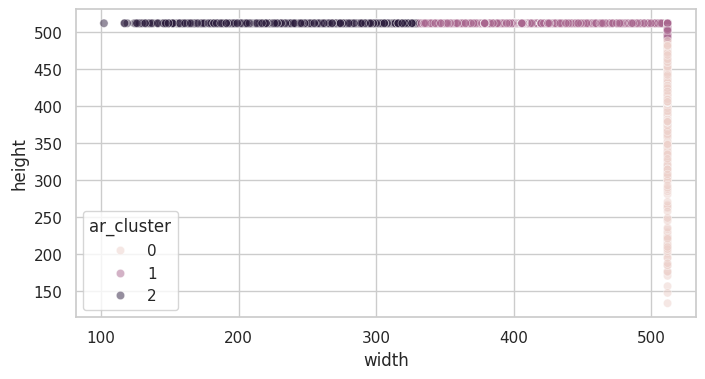

In [61]:
# 5. Визуализация кластеров
import seaborn as sns

sns.scatterplot(
    data=df_dimensions.sample(5000), 
    x='width', y='height', hue='ar_cluster', alpha=0.5
);

 -> График для XR_ELBOW сохранен: mura_dimensions_ALL_plot_XR_ELBOW.png


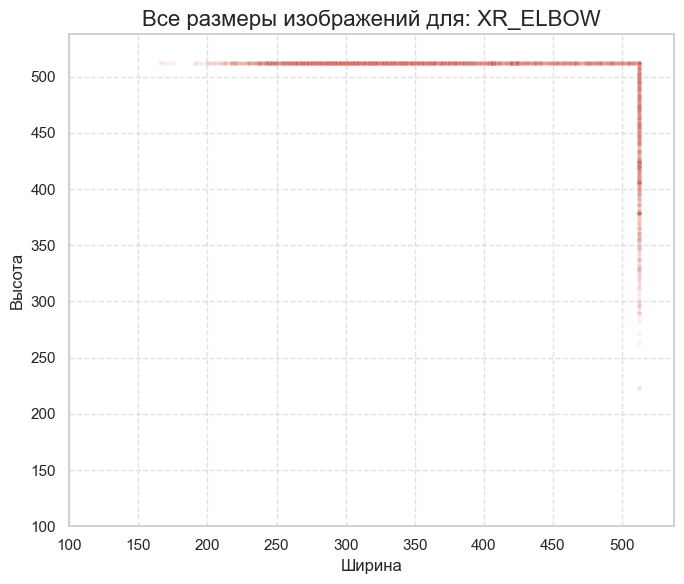

 -> График для XR_FINGER сохранен: mura_dimensions_ALL_plot_XR_FINGER.png


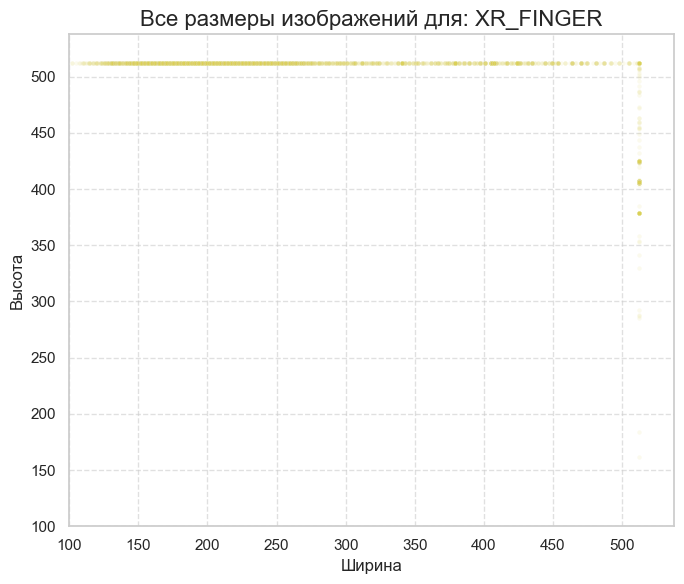

 -> График для XR_FOREARM сохранен: mura_dimensions_ALL_plot_XR_FOREARM.png


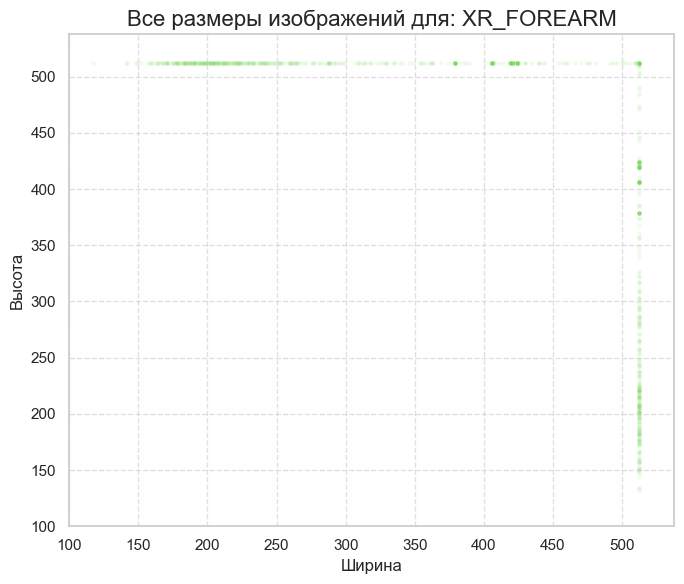

 -> График для XR_HAND сохранен: mura_dimensions_ALL_plot_XR_HAND.png


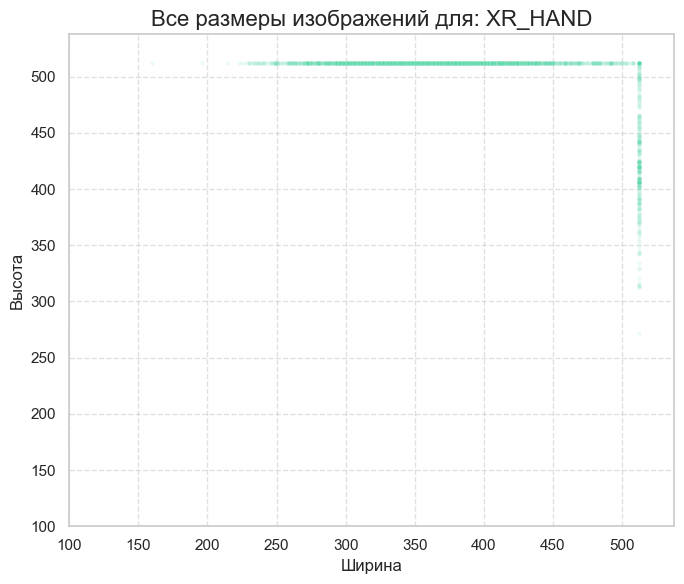

 -> График для XR_HUMERUS сохранен: mura_dimensions_ALL_plot_XR_HUMERUS.png


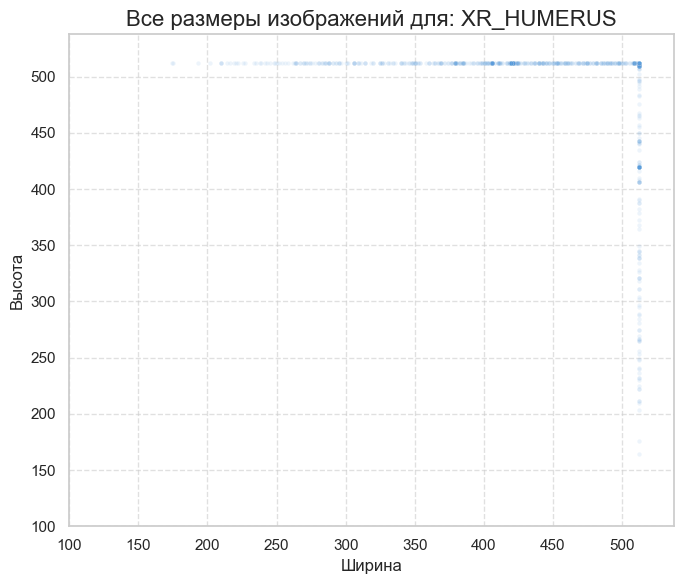

 -> График для XR_SHOULDER сохранен: mura_dimensions_ALL_plot_XR_SHOULDER.png


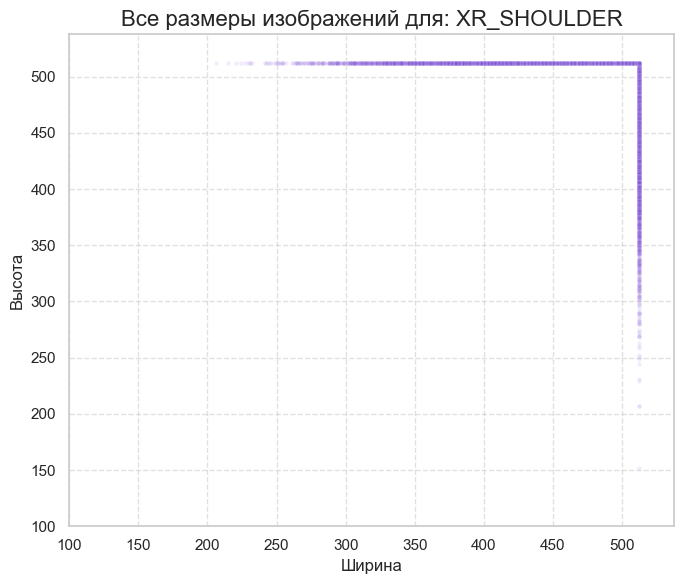

 -> График для XR_WRIST сохранен: mura_dimensions_ALL_plot_XR_WRIST.png


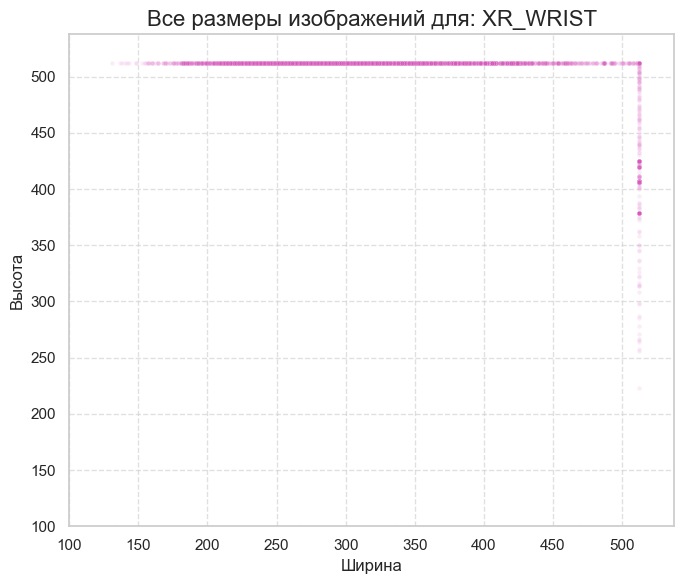

In [27]:
body_parts = df_dimensions['body_part'].unique()
colors = sns.color_palette("hls", len(body_parts))

# Определяем общие границы для осей X и Y для лучшего сравнения между графиками
max_width = df_dimensions['width'].max() * 1.05
max_height = df_dimensions['height'].max() * 1.05
min_dim = 100 

for idx, part in enumerate(sorted(body_parts)):
    df_part = df_dimensions[df_dimensions['body_part'] == part]
    plt.figure(figsize=(7, 6))
    sns.scatterplot(
        data=df_part,
        x='width',
        y='height',
        color=colors[idx], # Уникальный цвет для текущей части тела
        alpha=0.1,         # Высокая прозрачность, чтобы увидеть плотность
        s=10               # Маленькие точки для больших наборов данных
    )
    
    plt.xlim(min_dim, max_width)
    plt.ylim(min_dim, max_height)
    plt.title(f'Все размеры изображений для: {part}', fontsize=16)
    plt.xlabel('Ширина', fontsize=12)
    plt.ylabel('Высота', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    output_filename = f"mura_dimensions_ALL_plot_{part}.png"
    plt.savefig(output_filename)
    print(f" -> График для {part} сохранен: {output_filename}")
    plt.show()

Во всех случаях у нас либо длина, либо ширина изображения равна 512 пикселям. Стандартные размеры, которые мы используем, это $512 \times X$ или $Y \times 512$.

In [28]:
def find_outliers(df, num_std=3):
    """
    Находит выбросы (изображения с аномальными размерами) для каждой части тела,
    используя метод 3-х стандартных отклонений.
    """
    print(f"\nНачинаю поиск выбросов (размеры > {num_std} ст. отклонений от среднего)...")
    
    # 1. Считаем среднее и стандартное отклонение для ширины и высоты по каждой части тела
    stats = df.groupby('body_part')[['width', 'height']].agg(['mean', 'std'])
    
    outliers_list = []

    for part in df['body_part'].unique():
        df_part = df[df['body_part'] == part]
        
        # Получаем статистику для текущей части тела
        mean_w = stats.loc[part, ('width', 'mean')]
        std_w = stats.loc[part, ('width', 'std')]
        mean_h = stats.loc[part, ('height', 'mean')]
        std_h = stats.loc[part, ('height', 'std')]
        
        # Определяем границы для выбросов
        lower_w = int(mean_w - 2 * (num_std * std_w))
        upper_w = int(mean_w + 2 * (num_std * std_w))
        lower_h = int(mean_h - 2 * (num_std * std_h))
        upper_h = int(mean_h + 2 * (num_std * std_h))
        
        # Фильтруем строки, которые находятся вне этих границ
        outliers = df_part[
            (df_part['width'] < lower_w) | (df_part['width'] > upper_w) |
            (df_part['height'] < lower_h) | (df_part['height'] > upper_h)
        ]
        
        if not outliers.empty:
            outliers_list.append(outliers)

    if not outliers_list:
        print("Выбросы не найдены по критерию 3-х стандартных отклонений.")
        return pd.DataFrame()

    df_outliers = pd.concat(outliers_list)
    return df_outliers[['body_part', 'width', 'height', 'path']] # Возвращаем только нужные столбцы

# --- Выполнение поиска выбросов ---
df_outliers = find_outliers(df_dimensions, num_std=3) # Используем num_std=3 как общий критерий

if not df_outliers.empty:
    print("\n*** ОБНАРУЖЕНЫ ВЫБРОСЫ (Outliers) ***")
    print(f"Всего аномальных изображений: {len(df_outliers)}")
    
    # Показываем 10 примеров
    print("\nПервые 10 выбросов для ручного анализа:")
    print(df_outliers.head(10).to_string())
    
    # Сохраняем все выбросы для дальнейшего анализа
    output_filename = "mura_dimension_outliers.csv"
    df_outliers.to_csv(output_filename, index=False)
    print(f"\nСписок всех выбросов сохранен в: {output_filename}")
else:
    print("\nАнализ показал, что явных выбросов по критерию 3-х стандартных отклонений нет.")


Начинаю поиск выбросов (размеры > 3 ст. отклонений от среднего)...

*** ОБНАРУЖЕНЫ ВЫБРОСЫ (Outliers) ***
Всего аномальных изображений: 42

Первые 10 выбросов для ручного анализа:
       body_part  width  height                                                               path
5160   XR_FINGER    512     184  MURA-v1.1\train\XR_FINGER\patient01506\study1_negative\image3.png
8506   XR_FINGER    512     162  MURA-v1.1\train\XR_FINGER\patient04286\study2_negative\image3.png
12423    XR_HAND    512     343    MURA-v1.1\train\XR_HAND\patient03501\study1_positive\image1.png
12424    XR_HAND    512     349    MURA-v1.1\train\XR_HAND\patient03501\study1_positive\image2.png
12753    XR_HAND    512     315    MURA-v1.1\train\XR_HAND\patient05789\study1_negative\image1.png
12755    XR_HAND    512     272    MURA-v1.1\train\XR_HAND\patient05789\study1_negative\image3.png
12986    XR_HAND    512     334    MURA-v1.1\train\XR_HAND\patient07448\study1_negative\image3.png
13260    XR_HAND    512    

Все аномальные изображения — это, как правило, изображения рук или кистей.


Начинаю отображение первых 2 изображений-выбросов...


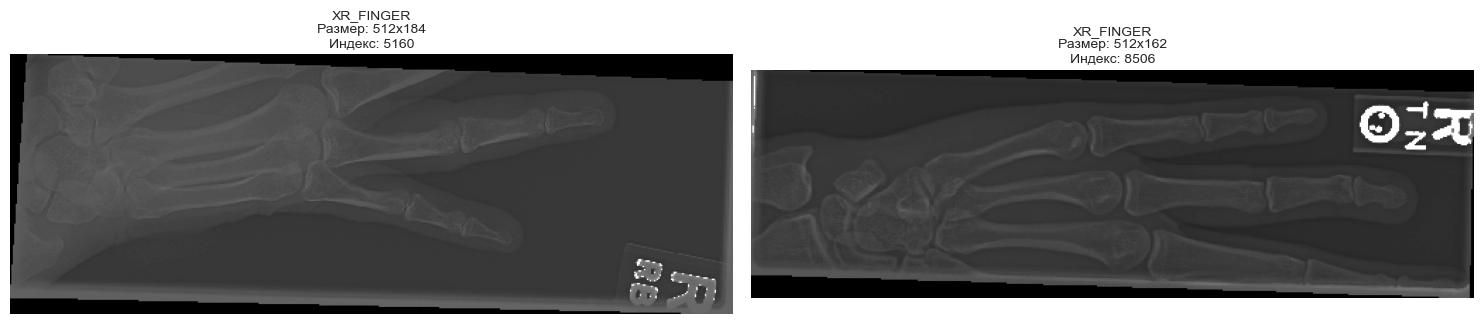


Визуализация завершена.


In [29]:
# Количество изображений для отображения
NUM_IMAGES_TO_SHOW = 2

if 'df_outliers' in locals() and not df_outliers.empty:
    
    # Берем первые N строк
    images_to_display = df_outliers.head(NUM_IMAGES_TO_SHOW)
    num_found = len(images_to_display)
    
    if num_found == 0:
        print("Не найдено изображений для отображения.")
    else:
        print(f"\nНачинаю отображение первых {num_found} изображений-выбросов...")

        # Настройка сетки для графиков (2 столбца)
        num_cols = 2
        # Вычисляем количество строк, округляя вверх
        num_rows = (num_found + num_cols - 1) // num_cols 
        
        plt.figure(figsize=(15, 5 * num_rows))
        
        # Используем enumerate для получения plot_index (от 0 до num_found-1)
        for plot_index, (original_index, row) in enumerate(images_to_display.iterrows()):
            file_path = row['path']
            body_part = row['body_part']
            width = row['width']
            height = row['height']
            
            # Добавляем подграфик: НОМЕР ЯЧЕЙКИ = plot_index + 1
            # plot_index будет 0, 1, 2...
            plt.subplot(num_rows, num_cols, plot_index + 1) # <--- ИСПРАВЛЕНИЕ ЗДЕСЬ
            
            try:
                img = Image.open(file_path)
                plt.imshow(img, cmap='gray')
                
                title = f"{body_part}\nРазмер: {width}x{height}\nИндекс: {original_index}"
                plt.title(title, fontsize=10)
                plt.axis('off')
                
            except Exception as e:
                plt.title(f"Ошибка открытия: {os.path.basename(file_path)}\n{e}", fontsize=8)
                plt.axis('off')
                
        plt.tight_layout()
        plt.show()
        print("\nВизуализация завершена.")

else:
    print("DataFrame 'df_outliers' не найден или пуст. Сначала запустите функцию find_outliers.")


In [30]:
BLACK_FILE_THRESHOLD = 5 
def get_body_part_from_path(file_path_str):
    parts = Path(file_path_str).parts
    for i, part in enumerate(parts):
        if part == 'train' or part == 'valid':
            return parts[i + 1]
    return None

def analyze_dataset_dimensions_with_integrity_check(base_dir):

    print(f"Начинаю сканирование с проверкой на черные файлы (Порог яркости < {BLACK_FILE_THRESHOLD}): {base_dir} ...")
    
    # DataFrame для рабочих файлов
    image_data = [] 
    # DataFrame для битых/черных файлов
    broken_files = [] 
    
    file_count = 0
    
    for root, _, files in os.walk(base_dir):
        for file in files:
            # Проверяем, что это PNG и не файл метаданных macOS (._)
            if file.endswith('.png') and not file.startswith('._'):
                file_path = os.path.join(root, file)
                body_part = get_body_part_from_path(file_path)
                
                if body_part is None:
                    continue
                
                is_black = False

                try:
                    # 1. Открываем изображение и принудительно читаем все данные
                    with Image.open(file_path) as img:
                        img.verify() 
                        img.load() 
                        
                        width, height = img.size
                        
                        # 2. Проверка на "Черный" файл
                        # Конвертируем в оттенки серого ('L') для расчета яркости
                        img_gray = img.convert('L') 
                        # Рассчитываем среднее значение яркости всех пикселей
                        mean_brightness = sum(img_gray.getdata()) / len(img_gray.getdata())
                        
                        if mean_brightness < BLACK_FILE_THRESHOLD:
                            is_black = True
                            broken_files.append({
                                'path': file_path, 
                                'reason': f'Too Dark (Avg. Brightness: {mean_brightness:.2f})', 
                                'body_part': body_part
                            })
                        
                        # Если файл рабочий и не черный, добавляем в рабочий список
                        if not is_black:
                             image_data.append({
                                'body_part': body_part,
                                'width': width,
                                'height': height,
                                'path': file_path
                            })
                            
                except Exception as e:
                    # Файл поврежден или не может быть открыт
                    broken_files.append({'path': file_path, 'reason': f'Broken/Corrupted: {e}', 'body_part': body_part})
                
                file_count += 1
                if file_count % 5000 == 0:
                    print(f"Обработано {file_count} изображений...")

    print(f"Сканирование завершено. Всего обработано {file_count} изображений.")
    
    df = pd.DataFrame(image_data)
    df_broken = pd.DataFrame(broken_files)
    
    return df, df_broken

# 1. Запуск сканирования и проверки
df_dimensions, df_broken_files = analyze_dataset_dimensions_with_integrity_check(DATA_ROOT)

print("\n" + "="*50)
print(f"РЕЗУЛЬТАТЫ ПРОВЕРКИ НА ЧЕРНЫЕ/БИТЫЕ ФАЙЛЫ")
print("="*50)

# 2. Фильтрация только черных файлов
df_black_files = df_broken_files[df_broken_files['reason'].str.startswith('Too Dark')].copy()


print(f"❌ Обнаружено полностью черных файлов: {len(df_black_files)}")


if not df_black_files.empty:
    print("\n*** ПЕРВЫЕ 10 ЧЕРНЫХ ФАЙЛОВ ***")
    
    # Показываем 10 примеров черных файлов
    print(df_black_files.head(10).to_string())
    
    # Сохраняем список черных файлов
    output_filename = "mura_black_files_only.csv"
    df_black_files.to_csv(output_filename, index=False)
    print(f"\nПолный список черных файлов сохранен в: {output_filename}")

Начинаю сканирование с проверкой на черные файлы (Порог яркости < 5): MURA-v1.1 ...
Обработано 5000 изображений...
Обработано 10000 изображений...
Обработано 15000 изображений...
Обработано 20000 изображений...
Обработано 25000 изображений...
Обработано 30000 изображений...
Обработано 35000 изображений...
Обработано 40000 изображений...
Сканирование завершено. Всего обработано 40005 изображений.

РЕЗУЛЬТАТЫ ПРОВЕРКИ НА ЧЕРНЫЕ/БИТЫЕ ФАЙЛЫ
❌ Обнаружено полностью черных файлов: 0


Во время проверки пустых картинок не обнаруженно, они все могут быть пременены для обучения модели

### Анализ каналов и цветов

In [31]:
BASE_DATA_DIR = Path(DATA_ROOT) 

for CSV_FILE_PATH in [BASE_DATA_DIR / "train_image_paths.csv", BASE_DATA_DIR / "valid_image_paths.csv"]:

    N_SAMPLES_TO_CHECK = 10000
    unique_channels = set()
    unique_dtypes = set()  # dtype = глубина цвета (uint8, uint16)
    unique_shapes = set()

    print(f"Загружаю CSV: {CSV_FILE_PATH}")
    try:
        df = pd.read_csv(CSV_FILE_PATH, header=None, index_col=False, names=["image_path"])
    except FileNotFoundError:
        print(f"ОШИБКА: Файл {CSV_FILE_PATH} не найден.")
        print("Пожалуйста, проверьте путь в BASE_DATA_DIR.")
        exit()

    sample_paths = df["image_path"].sample(frac=1, random_state=42).head(N_SAMPLES_TO_CHECK)

    print(f"Начинаю проверку {N_SAMPLES_TO_CHECK} случайных изображений...")

    for rel_path_str in tqdm(sample_paths):
        full_img_path = Path(rel_path_str)
        
        if not full_img_path.exists():
            print(f"\n[Внимание] Файл не найден: {full_img_path}")
            continue
            
        # Читаем изображение, сохраняя его ОРИГИНАЛЬНУЮ глубину
        img = cv2.imread(str(full_img_path), cv2.IMREAD_UNCHANGED)

        if img is None:
            print(f"\n[Внимание] Не удалось прочитать: {full_img_path}")
            continue

        # --- 1. Проверяем каналы ---
        if img.ndim == 2:
            # ndim == 2 означает 2D-массив (высота, ширина) -> 1 канал
            channels = 1
        elif img.ndim == 3:
            # ndim == 3 означает 3D-массив (высота, ширина, каналы)
            channels = img.shape[2]
        else:
            channels = "Неизвестная структура"
            
        unique_channels.add(channels)
        
        # --- 2. Проверяем глубину (dtype) ---
        unique_dtypes.add(img.dtype)

        # --- (Бонус) Собираем уникальные размеры ---
        unique_shapes.add(img.shape[:2]) # Берем только (высота, ширина)

    print("\n--- EDA Завершено. Результаты: ---")
    print(f"Найденные типы каналов: {unique_channels}")
    print(f"Найденные типы глубины (dtype): {unique_dtypes}")
    print(f"Количество уникальных размеров (shape) в выборке: {len(unique_shapes)}")

    if len(unique_shapes) > 10:
        print(" -> Обнаружено много разных размеров изображений.")
    else:
        print(f" -> Найденные размеры: {unique_shapes}")
        
    if "uint16" in str(unique_dtypes):
        print(" -> ВНИМАНИЕ: Найдены 16-битные изображения. Их нужно будет " \
            "корректно нормализовать (не просто делить на 255).")
    if 1 in unique_channels:
        print(" -> Найдены 1-канальные (grayscale) изображения.")
    if 3 in unique_channels:
        print(" -> Найдены 3-канальные (RGB) изображения.")

Загружаю CSV: MURA-v1.1\train_image_paths.csv
Начинаю проверку 10000 случайных изображений...


100%|██████████| 10000/10000 [00:11<00:00, 842.61it/s]



--- EDA Завершено. Результаты: ---
Найденные типы каналов: {1, 3}
Найденные типы глубины (dtype): {dtype('uint8')}
Количество уникальных размеров (shape) в выборке: 642
 -> Обнаружено много разных размеров изображений.
 -> Найдены 1-канальные (grayscale) изображения.
 -> Найдены 3-канальные (RGB) изображения.
Загружаю CSV: MURA-v1.1\valid_image_paths.csv
Начинаю проверку 10000 случайных изображений...


100%|██████████| 3197/3197 [00:03<00:00, 840.74it/s]


--- EDA Завершено. Результаты: ---
Найденные типы каналов: {1, 3}
Найденные типы глубины (dtype): {dtype('uint8')}
Количество уникальных размеров (shape) в выборке: 537
 -> Обнаружено много разных размеров изображений.
 -> Найдены 1-канальные (grayscale) изображения.
 -> Найдены 3-канальные (RGB) изображения.


### Анализ качества изображений в датасете

#### 1. Проверка цветового представления изображений (RGB, RGBA, grayscale)

In [32]:
# датасет
image_dir = 'MURA-v1.1'

#Пути к файлам
image_paths = []
for root, dirs, files in os.walk(image_dir):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_paths.append(os.path.join(root, file))

In [33]:
def get_image_type(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if img is None:
        return "unreadable"
    shape = img.shape
    if len(shape) == 2:
        return "grayscale"
    elif len(shape) == 3:
        if shape[2] == 3:
            return "RGB"
        elif shape[2] == 4:
            return "RGBA"
        else:
            return "unknown"
    else:
        return "unknown"

#считаем количество изображений каждого типа
results = []
for path in tqdm(image_paths, disable=True):
    img_type = get_image_type(path)
    results.append({"path": path, "type": img_type})

df = pd.DataFrame(results)

In [34]:
print("Распределение типов изображений:")
for img_type, count in df['type'].value_counts().items():
    print(f" {img_type:<12} — {count} файлов")

Распределение типов изображений:
 grayscale    — 24016 файлов
 RGB          — 15989 файлов
 unreadable   — 4 файлов


Из анализа видно, что часть изображений в цветовом представлении RGB. Это может затруднить обработку. Проверим действительно ли это цветные изображения, так как для датасета рентген - изображений это не характерно.

In [35]:
def is_rgb_grayscale(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if img is None or len(img.shape) != 3 or img.shape[2] != 3:
        return None
    b, g, r = cv2.split(img)
    return np.array_equal(b, g) and np.array_equal(b, r)

df['rgb_is_gray'] = None

rgb_df = df[df['type'] == 'RGB'].copy()

for i, row in tqdm(rgb_df.iterrows(), total=len(rgb_df), disable=True):
    is_gray = is_rgb_grayscale(row['path'])
    df.at[i, 'rgb_is_gray'] = is_gray

df['rgb_is_gray'].value_counts(dropna=True)

rgb_is_gray
True    15989
Name: count, dtype: int64

Дополнительный анализ показал, что все 15989 изображений, закодированных как RGB на самом деле являются grayscale. Пометим их как grayscale в датасете и пересчитаем типы изображений

In [36]:
df['rgb_is_gray'] = None
from tqdm import tqdm

rgb_indices = df[df['type'] == 'RGB'].index

for i in tqdm(rgb_indices, disable=True):
    path = df.at[i, 'path']
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if img is not None and len(img.shape) == 3 and img.shape[2] == 3:
        b, g, r = cv2.split(img)
        df.at[i, 'rgb_is_gray'] = np.array_equal(b, g) and np.array_equal(b, r)
    else:
        df.at[i, 'rgb_is_gray'] = False


In [37]:
df.loc[(df['type'] == 'RGB') & (df['rgb_is_gray'] == True), 'type'] = 'grayscale'
print(df['type'].value_counts())


type
grayscale     40005
unreadable        4
Name: count, dtype: int64


#### 2. Следующим этапом оценим контраст и динамический диапазон изображений. Выясним есть ли слишком темные или слишком светлые изображения, снимки с низким контрастом и какие значения яркости используются.

Хорошее изображение использует весь диапазон и имеет заметный контраст.

In [38]:
def get_brightness_stats(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if img is None:
        return None
    # Переводим RGB в grayscale
    if len(img.shape) == 3 and img.shape[2] == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    stats = {
        'min': int(img.min()),
        'max': int(img.max()),
        'mean': float(img.mean()),
        'std': float(img.std()),
        'range': int(img.max() - img.min())
    }
    return stats

Собираем данные в датафрейм

In [39]:
brightness_data = []

for i, row in tqdm(df.iterrows(), total=len(df), disable=True):
    if row['type'] == 'grayscale':
        stats = get_brightness_stats(row['path'])
        if stats:
            brightness_data.append({**stats, 'path': row['path']})

brightness_df = pd.DataFrame(brightness_data)
print(brightness_df.describe())

                min           max          mean           std         range
count  40005.000000  40005.000000  40005.000000  40005.000000  40005.000000
mean       4.667817    231.931209     52.388956     31.415347    227.263392
std       11.913300     41.106640     29.594850     13.174918     40.794377
min        0.000000      5.000000      0.002530      0.318558      5.000000
25%        0.000000    219.000000     36.170346     22.357929    215.000000
50%        0.000000    255.000000     46.687069     28.719572    254.000000
75%        1.000000    255.000000     57.552282     37.101889    255.000000
max      129.000000    255.000000    179.963207    109.455655    255.000000


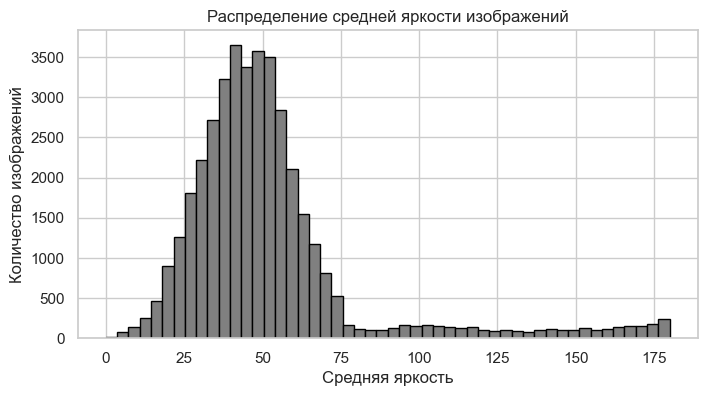

In [40]:
# Гистограмма средней яркости
plt.figure(figsize=(8,4))
plt.hist(brightness_df['mean'], bins=50, color='gray', edgecolor='black')
plt.title('Распределение средней яркости изображений')
plt.xlabel('Средняя яркость')
plt.ylabel('Количество изображений')
plt.grid(True)
plt.show()

Большинство изображений имеют среднюю яркость, что характерно для рентген-изображений. Изображения слева со значением < 20 потенциально слишком темные, изображения справа со значением >100 могут быть с повышенной яркостью

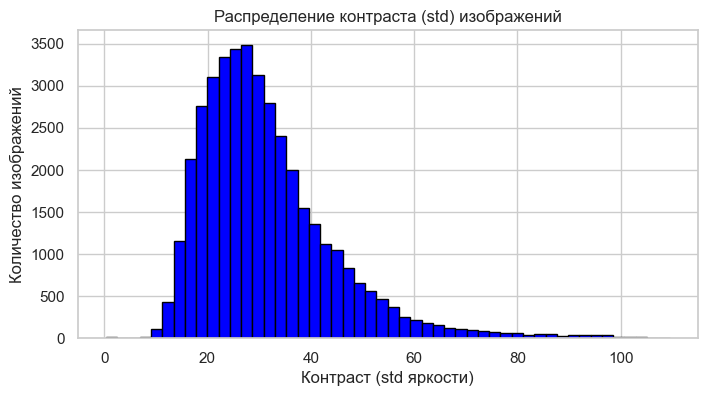

In [41]:
# Гистограмма стандартного отклонения (контраста)
plt.figure(figsize=(8,4))
plt.hist(brightness_df['std'], bins=50, color='blue', edgecolor='black')
plt.title('Распределение контраста (std) изображений')
plt.xlabel('Контраст (std яркости)')
plt.ylabel('Количество изображений')
plt.grid(True)
plt.show()

Распределение контраста имеет пик в диапазоне 20–30, что считается нормой. Есть некоторые изображения со значениями <15, что говорит о низком контрасте. Что касается снимков со значениями >50, скорее всего это изображения с сильными перепадами или шумом.

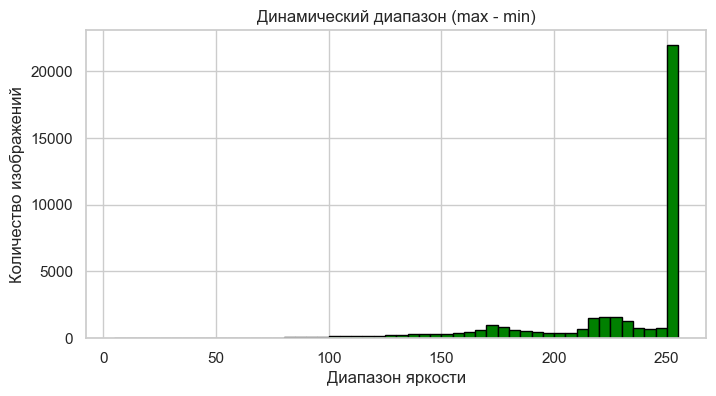

In [43]:
# Гистограмма динамического диапазона (max - min)
plt.figure(figsize=(8,4))
plt.hist(brightness_df['range'], bins=50, color='green', edgecolor='black')
plt.title('Динамический диапазон (max - min)')
plt.xlabel('Диапазон яркости')
plt.ylabel('Количество изображений')
plt.grid(True)
plt.show()

Данные этого графика показывают, что абсолютное большинство изображений имеет полный диапазон, что говорит о том, что они используют весь доступный диапазон яркости. Изображения со значением <30 почти не имеют контраста.

#### 3. Оценим резкость изображений для выделения количества размытых снимков, которые могут затруднить дальнейшее обучение.

In [44]:
# функция для вычисления резкости, предложенная Chat GPT

def compute_blur_score(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if img is None:
        return None
    if len(img.shape) == 3 and img.shape[2] == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Вычисляем вариацию Лапласиана
    laplacian_var = cv2.Laplacian(img, cv2.CV_64F).var()
    return laplacian_var

In [45]:
# Применяем функцию к изображениям
blur_scores = []

for i, row in tqdm(df.iterrows(), total=len(df), disable=True):
    if row['type'] == 'grayscale':  # только для валидных изображений
        score = compute_blur_score(row['path'])
        if score is not None:
            blur_scores.append({'path': row['path'], 'blur_var': score})
blur_df = pd.DataFrame(blur_scores)

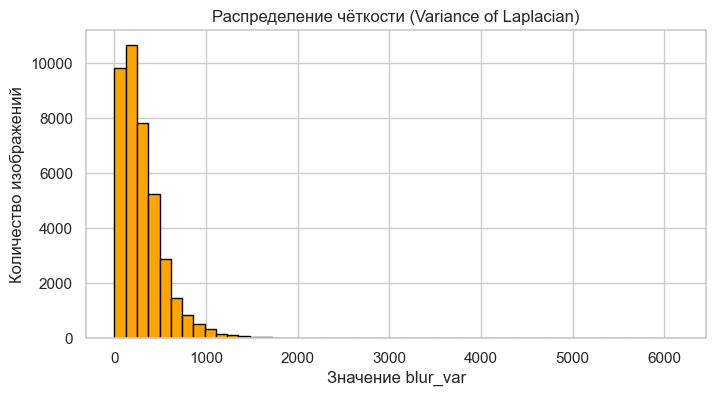

In [46]:
# Визуализация
plt.figure(figsize=(8,4))
plt.hist(blur_df['blur_var'], bins=50, color='orange', edgecolor='black')
plt.title("Распределение чёткости (Variance of Laplacian)")
plt.xlabel("Значение blur_var")
plt.ylabel("Количество изображений")
plt.grid(True)
plt.show()

Большая часть изображений сосредоточена в области 0–500, с пиком до 200–300. Это означает, что многие изображения либо слегка размыты, либо имеют мягкие границы. Изображения с размером 150-500 умеренно резкие, 500+ четкие, с выраженными границами. 1500-2000 могут быть сильно шумными.

In [47]:
# доля потенциально размытых изображений
num_blurry = (blur_df['blur_var'] < 50).sum()
total = len(blur_df)
print(f"🔍 Сильно размытых изображений: {num_blurry} из {total} ({num_blurry/total:.2%})")

🔍 Сильно размытых изображений: 1813 из 40005 (4.53%)


### Визуализация разных исследований

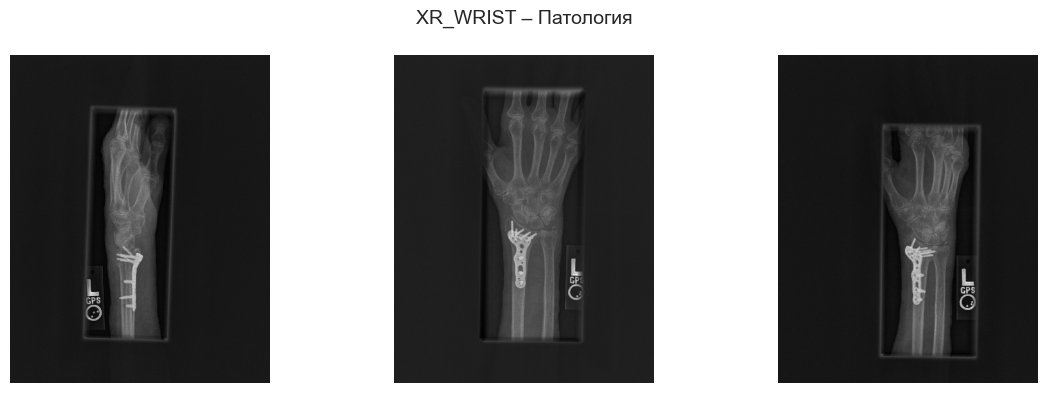

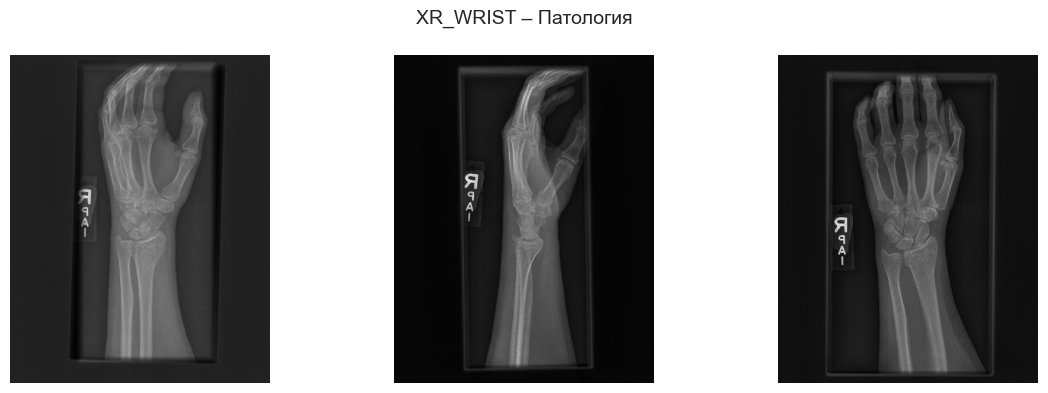

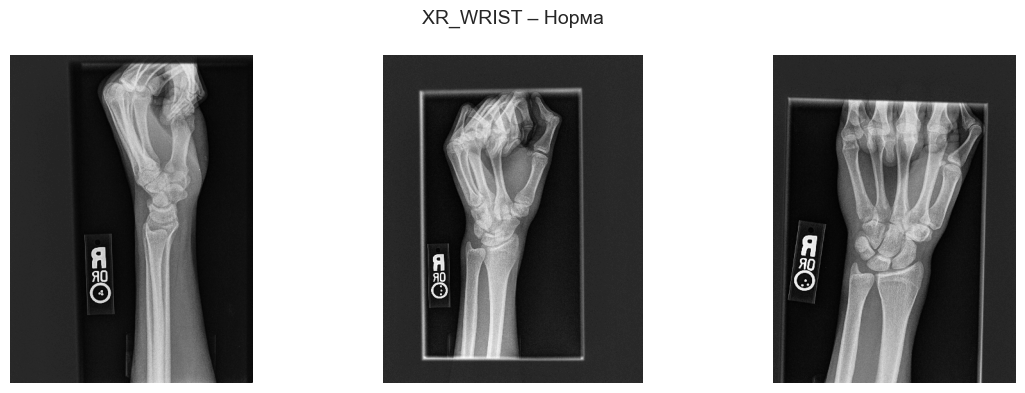

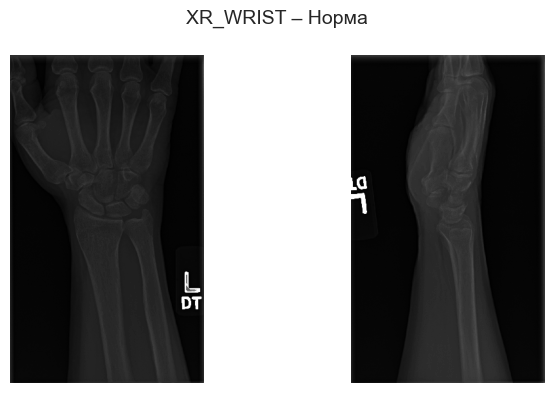

In [22]:
def show_examples(anatomy: str, label: int, n_studies: int = 2):
    subset = df[(df['anatomy'] == anatomy) & (df['label'] == label)].sample(n_studies, random_state=42)
    for _, row in subset.iterrows():
        image_files = [os.path.join(row['path'], f) 
                       for f in os.listdir(row['path']) 
                       if f.lower().endswith(('.png', '.jpg'))]
        n_imgs = min(3, len(image_files))
        fig, axes = plt.subplots(1, n_imgs, figsize=(4 * n_imgs, 4))
        if n_imgs == 1:
            axes = [axes]
        for ax, img_path in zip(axes, image_files[:n_imgs]):
            img = Image.open(img_path).convert('L')
            ax.imshow(img, cmap='gray')
            ax.axis('off')
        title = f"{anatomy} – {'Патология' if label else 'Норма'}"
        fig.suptitle(title, fontsize=14)
        plt.tight_layout()
        plt.show()

# Пример: запястье (патология и норма)
show_examples('XR_WRIST', label=1)
show_examples('XR_WRIST', label=0)


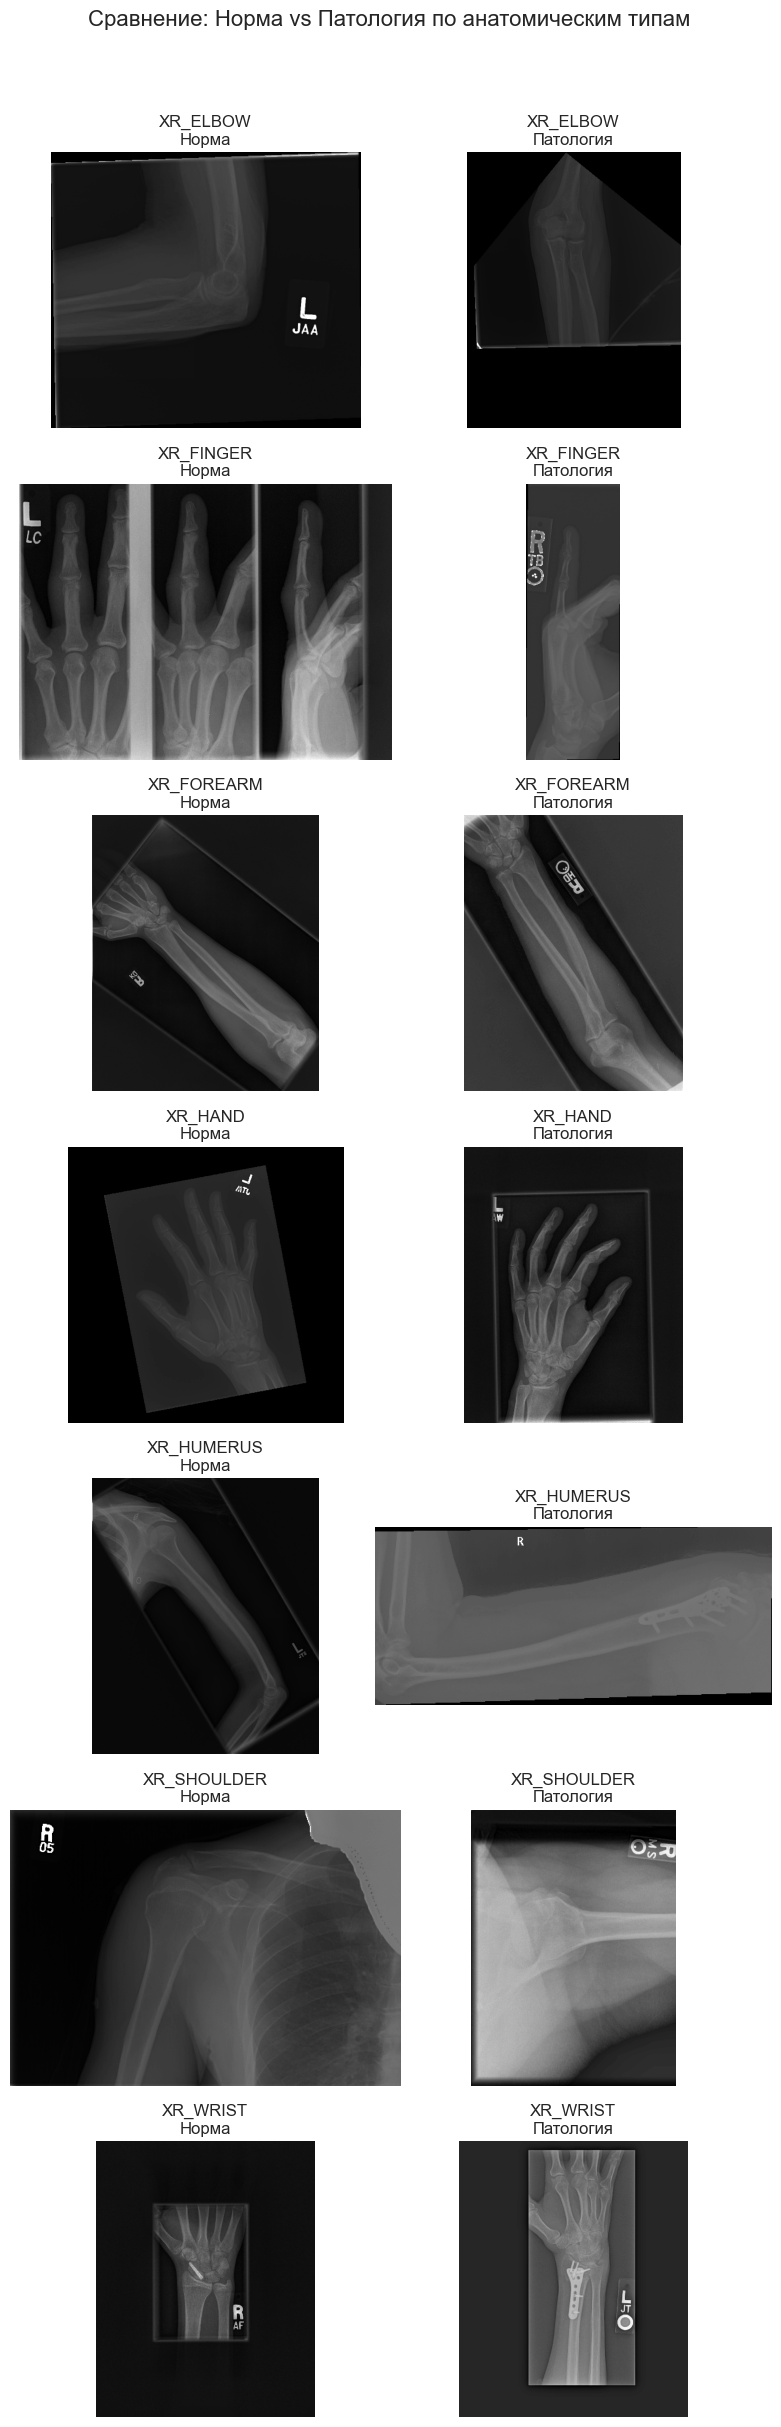

In [23]:
anatomy_list = sorted(df['anatomy'].unique())
n_cols = 2  # Норма / Патология
n_rows = len(anatomy_list)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(8, 3.5 * n_rows))
fig.suptitle("Сравнение: Норма vs Патология по анатомическим типам", fontsize=16, y=0.99)

for i, anatomy in enumerate(anatomy_list):
    for j, label in enumerate([0, 1]):  # 0 = норма, 1 = патология
        subset = df[(df['anatomy'] == anatomy) & (df['label'] == label)]
        if len(subset) == 0:
            axes[i, j].text(0.5, 0.5, "Нет данных", ha='center', va='center')
            axes[i, j].axis('off')
            continue
        
        # Берём первое исследование
        study_path = subset.iloc[0]['path']
        image_files = [os.path.join(study_path, f) for f in os.listdir(study_path)
                       if f.lower().endswith(('.png', '.jpg'))]
        if not image_files:
            axes[i, j].text(0.5, 0.5, "Нет изображений", ha='center', va='center')
            axes[i, j].axis('off')
            continue
        
        # Берём первый снимок
        img = Image.open(image_files[0]).convert('L')
        axes[i, j].imshow(img, cmap='gray')
        axes[i, j].axis('off')
        axes[i, j].set_title(f"{anatomy}\n{'Патология' if label else 'Норма'}", fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

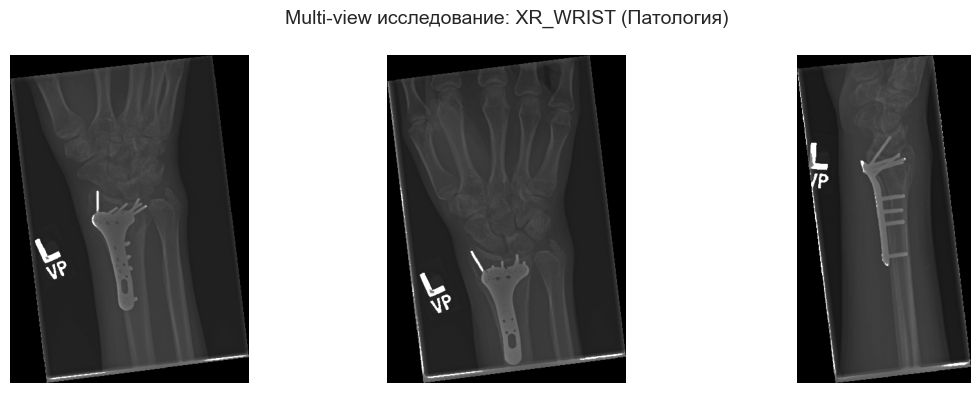

In [24]:
# Выберем одно multi-view исследование с патологией
multi_study = df[(df['label'] == 1) & (df['n_images'] >= 2)].sample(1).iloc[0]
study_path = multi_study['path']
anatomy = multi_study['anatomy']

image_files = sorted([os.path.join(study_path, f) for f in os.listdir(study_path)
                      if f.lower().endswith(('.png', '.jpg'))])

n_imgs = len(image_files)
fig, axes = plt.subplots(1, n_imgs, figsize=(4 * n_imgs, 4))
if n_imgs == 1:
    axes = [axes]

for ax, img_path in zip(axes, image_files):
    img = Image.open(img_path).convert('L')
    ax.imshow(img, cmap='gray')
    ax.axis('off')

fig.suptitle(f"Multi-view исследование: {anatomy} (Патология)", fontsize=14)
plt.tight_layout()
plt.show()

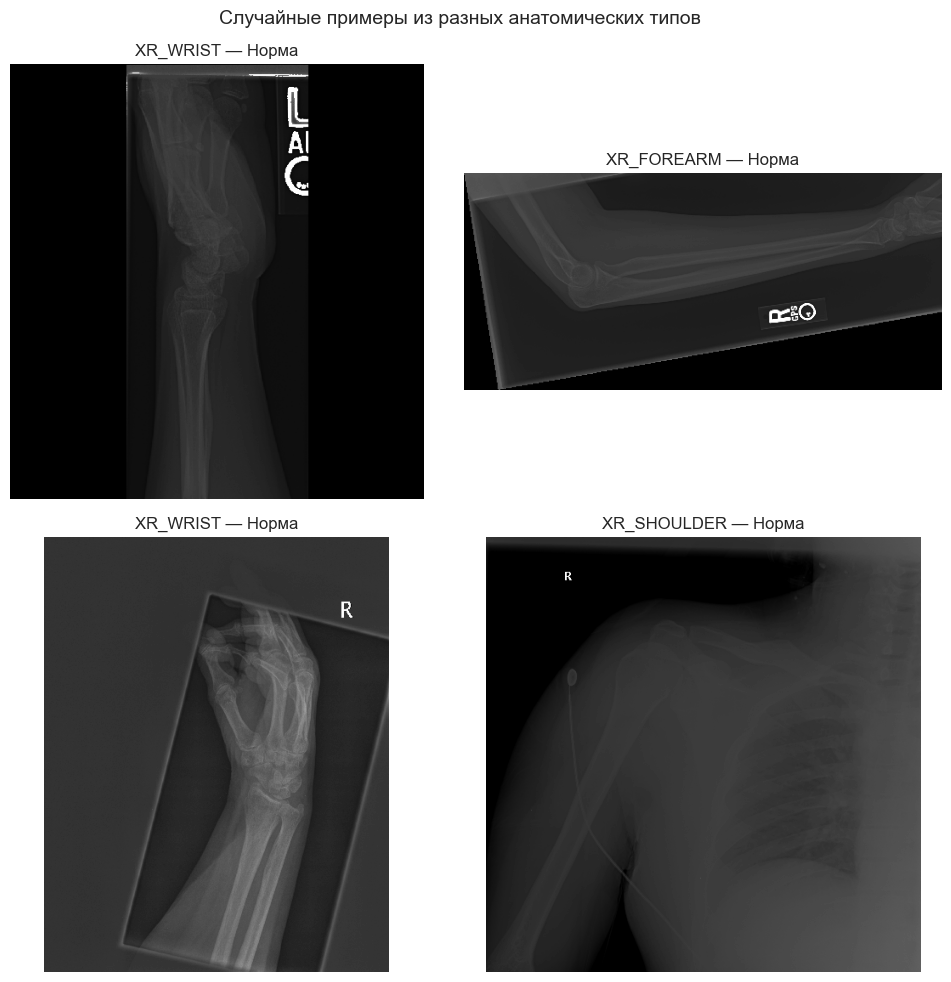

In [25]:
np.random.seed(42)
sample_studies = df.sample(4)

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()

for idx, (_, row) in enumerate(sample_studies.iterrows()):
    study_path = row['path']
    image_files = [os.path.join(study_path, f) for f in os.listdir(study_path)
                   if f.lower().endswith(('.png', '.jpg'))]
    if not image_files:
        continue
    img = Image.open(image_files[0]).convert('L')
    axes[idx].imshow(img, cmap='gray')
    axes[idx].axis('off')
    axes[idx].set_title(f"{row['anatomy']} — {'Патология' if row['label'] else 'Норма'}", fontsize=12)

plt.suptitle("Случайные примеры из разных анатомических типов", fontsize=14)
plt.tight_layout()
plt.show()